## Final Project Submission

Please fill out:
* Student name: Sabatino Chen
* Student pace: full time 
* Scheduled project review date/time: 4/10/2019 11AM EST
* Instructor name: Joe San Pietro
* Blog post URL: ??


## Content
- GAME_ID
- MATCHUP
- LOCATION (Home (H) or Away (A))
- GAME_RESULT (Win and Lose)
- FINAL_MARGIN
- SHOT_NUMBER
- PERIOD (Quarter/Overtime)
- GAME_CLOCK
- SHOT_CLOCK
- DRIBBLES
- TOUCH_TIME
- SHOT_DIST (ft)
- PTS_TYPE
- SHOT_RESULT
- CLOSEST_DEFENDER
- CLOSEST_DEFENDER_PLAYER_ID
- CLOSE_DEF_DIST
- FGM
- PTS
- player_name
- player_id
- SHOOTER_height (ft)
- DEFENDER_height (ft)


## Objective
Will be using the OSEMN system for a dataset of shot attempts during each game of the NBA 2014-2015 season. Will use this data to examine trends as well as make classifier models in order to predict whether the shot was made or missed.

## Obtain

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [2]:
df = pd.read_csv('shot_logs_Height.csv')
df.head()

,GAME_ID,MATCHUP,LOCATION,GAME_RESULT,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,SHOOTER_height,DEFENDER_height
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,made,Alan Anderson,101187,1.3,1,2,brian roberts,203148,73,78
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,missed,Bojan Bogdanovic,202711,6.1,0,0,brian roberts,203148,73,80
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,missed,Bojan Bogdanovic,202711,0.9,0,0,brian roberts,203148,73,80
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,missed,Markel Brown,203900,3.4,0,0,brian roberts,203148,73,75
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,missed,Thaddeus Young,201152,1.1,0,0,brian roberts,203148,73,80


In [3]:
df.shape

(128069, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 23 columns):
GAME_ID                       128069 non-null int64
MATCHUP                       128069 non-null object
LOCATION                      128069 non-null object
GAME_RESULT                   128069 non-null object
FINAL_MARGIN                  128069 non-null int64
SHOT_NUMBER                   128069 non-null int64
PERIOD                        128069 non-null int64
GAME_CLOCK                    128069 non-null object
SHOT_CLOCK                    128069 non-null float64
DRIBBLES                      128069 non-null int64
TOUCH_TIME                    128069 non-null float64
SHOT_DIST                     128069 non-null float64
PTS_TYPE                      128069 non-null int64
SHOT_RESULT                   128069 non-null object
CLOSEST_DEFENDER              128069 non-null object
CLOSEST_DEFENDER_PLAYER_ID    128069 non-null int64
CLOSE_DEF_DIST                128069 non-null

## Scrub

In [5]:
# Check for nulls
df.isna().any()

GAME_ID                       False
MATCHUP                       False
LOCATION                      False
GAME_RESULT                   False
FINAL_MARGIN                  False
SHOT_NUMBER                   False
PERIOD                        False
GAME_CLOCK                    False
SHOT_CLOCK                    False
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
SHOT_RESULT                   False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
PTS                           False
player_name                   False
player_id                     False
SHOOTER_height                False
DEFENDER_height               False
dtype: bool

In [6]:
# function to convert time string format into seconds (integer)
def get_sec(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

In [7]:
# Drop 'matchup' since designated in 'location'
df.drop('MATCHUP', axis=1, inplace=True)

# Change 'location' to binary: 0 = A, 1 = H
df.LOCATION.replace(to_replace=['A', 'H'], value=[0, 1], inplace=True)

# Drop 'game_result' since doesn't effect each individual shot during the game
# 'final_margin' does a better job at explaining intensity of the game.
df.drop('GAME_RESULT', axis=1, inplace=True)

# Change 'game_clock' to seconds
df['GAME_CLOCK'] = df['GAME_CLOCK'].apply(get_sec)

# Drop 'shot_result' since the same as 'FGM' (target variable)
df.drop('SHOT_RESULT', axis=1, inplace=True)

Above dropped the columns that weren't necessary for exploring or modelling. Also converted the game clock feature into total seconds in comparison with the shot clock time.
<br>

After cleaning up some of the obvious features, will look at histograms to see if further cleaning is required

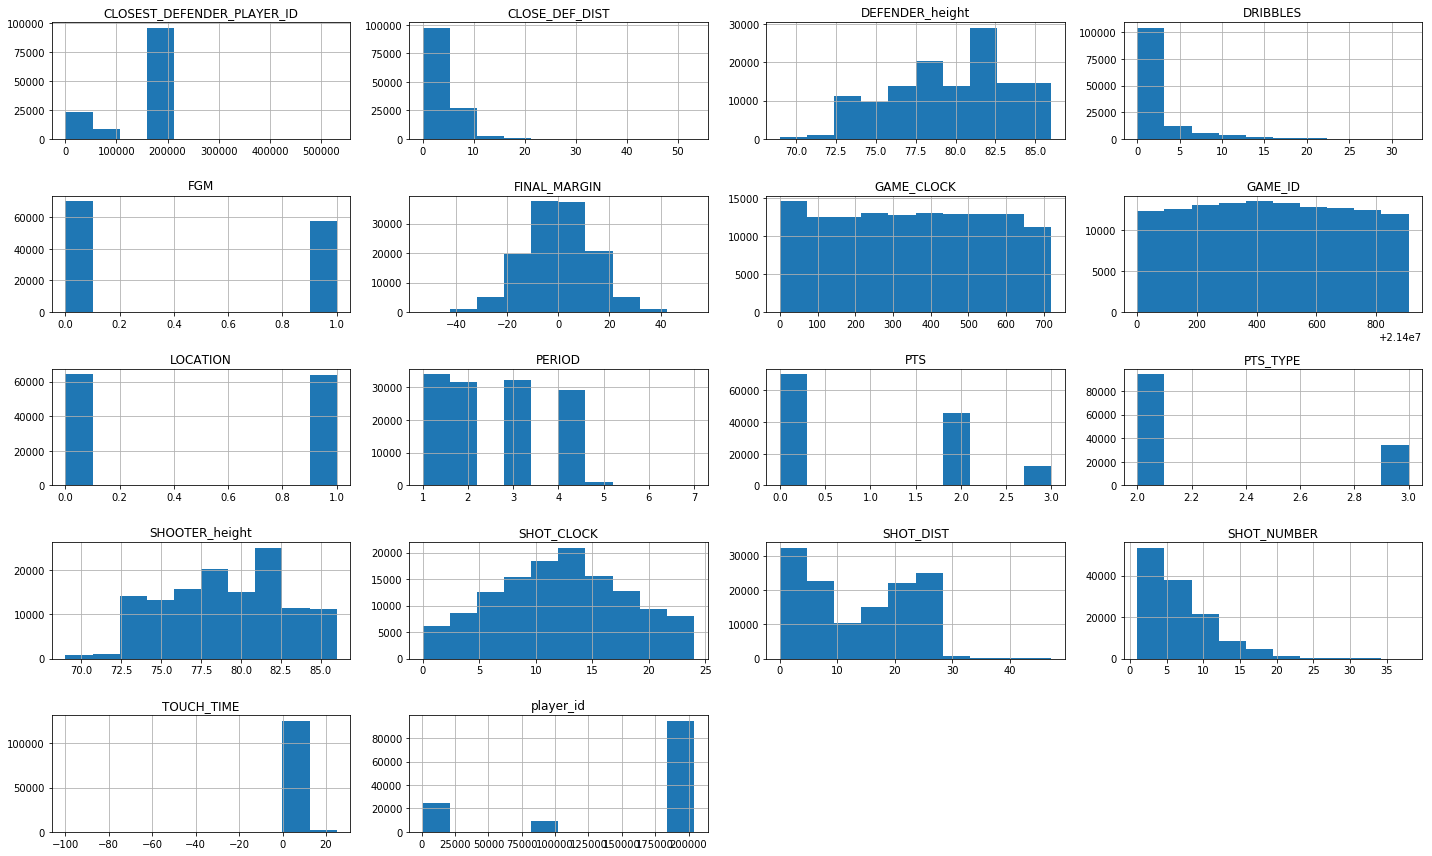

In [8]:
df.hist(figsize=(20,12))
plt.tight_layout()
plt.show()

Seems that the feature TOUCH_TIME has some negative values. Also there seems to be some obvious outliers for SHOT_DIST that we can remove because they will greatly skew the data and a desperation shot from very far away doesn't represent the dataset. The rest of the features look good.

In [9]:
print(df.SHOT_DIST.max())

47.2


In [10]:
print('% of rows with negative touch times:', len(df[df['TOUCH_TIME']<0])/len(df))

# Can drop these since it is a very small portion of the dataset
df.drop(df[df['TOUCH_TIME']<=0].index, inplace=True)

% of rows with negative touch times: 0.002436186743083806


In [11]:
# shots that are too far, desperation shots
print('% of rows with shot dist > 40:', len(df[df['SHOT_DIST']>40])/len(df))

# Can drop these since it is a very small portion of the dataset
df.drop(df[df['SHOT_DIST']>40].index, inplace=True)

% of rows with shot dist > 40: 0.0008178909639085565


In [12]:
# Incorrect 2s and 3s
print('# of incorrect 2s:', len(df[(df['PTS_TYPE']==2)&(df['SHOT_DIST']>23.9)]))
print('# of incorrect 3s:', len(df[(df['PTS_TYPE']==3)&(df['SHOT_DIST']<=22)]))

# of incorrect 2s: 368
# of incorrect 3s: 1063


In [13]:
(368+1063)/len(df)

0.011483921707099809

Above notice that there are some errors in the dataset.  A 3 point shot is considered when a player shoots from behind the 3 point line.  There are two distances for 3 point shots, the majority being 23.75 feet while on either side of the hoop, called the corners, the distance is 22 feet.  Since the amount of incorrectly labeled data is small we can drop these rows.

![title](nba_court.png)

In [14]:
df.drop(df[(df['PTS_TYPE']==2)&(df['SHOT_DIST']>23.9)].index, inplace=True)
df.drop(df[(df['PTS_TYPE']==3)&(df['SHOT_DIST']<=22)].index, inplace=True)
df.shape

(123178, 20)

In [15]:
df.head()

,GAME_ID,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,SHOOTER_height,DEFENDER_height
0,21400899,0,24,1,1,69,10.8,2,1.9,7.7,2,Alan Anderson,101187,1.3,1,2,brian roberts,203148,73,78
1,21400899,0,24,2,1,14,3.4,0,0.8,28.2,3,Bojan Bogdanovic,202711,6.1,0,0,brian roberts,203148,73,80
2,21400899,0,24,3,1,0,0.0,3,2.7,10.1,2,Bojan Bogdanovic,202711,0.9,0,0,brian roberts,203148,73,80
3,21400899,0,24,4,2,707,10.3,2,1.9,17.2,2,Markel Brown,203900,3.4,0,0,brian roberts,203148,73,75
4,21400899,0,24,5,2,634,10.9,2,2.7,3.7,2,Thaddeus Young,201152,1.1,0,0,brian roberts,203148,73,80


### Feature Engineering
Now that the data is cleaned up, will do some feature engineering to better suit future modelling and exploration.

In [16]:
# Make function to determine if a shot was contested or not
def contested_shot(distance):
    if distance <= 2:
        return 1
    else:
        return 0

# Make last second shot function
def last_second_shot(shot_clock_time):
    if shot_clock_time < 5:
        return 1
    else:
        return 0

# Make quick shot function
def quick_shot(shot_clock_time):
    if shot_clock_time > 16:
        return 1 
    else:
        return 0

# Make shot distance category function
def shot_distance_category(distance):
    if distance <= 8:
        return 'close-range'
    elif 8 < distance <= 16:
        return 'mid-range'
    elif 16 < distance <= 22:
        return 'long twos'
    elif 22 < distance <= 30:
        return 'threes'
    else:
        return 'deep threes'

In [17]:
# Repalce 0 values for 0.1 so don't get infinity when feature engineering
df.SHOT_DIST.replace(to_replace=0.0, value=0.1, inplace=True)

In [18]:
# Create contested shot feature
df['contested_shot'] = df['CLOSE_DEF_DIST'].apply(contested_shot)

#Create last second shot feature
df['last_second_shot'] = df['SHOT_CLOCK'].apply(last_second_shot)

# Create quick shot feature
df['quick_shot'] = df['SHOT_CLOCK'].apply(quick_shot)

# Create height difference feature between the shooter and the defender
df['height_diff'] = (df['SHOOTER_height'] - df['DEFENDER_height'])
df.head()

# Create dribble rate feature (dribbles per second of touch time)
df['dribble_rate'] = (df['DRIBBLES']/df['TOUCH_TIME'])

# Create shot distance category feature
df['shot_distance_category'] = df['SHOT_DIST'].apply(shot_distance_category)

# Create openness feature (CLOSE_DEF_DIST/SHOT_DIST)
df['openness'] = (df['CLOSE_DEF_DIST']/df['SHOT_DIST'])

Above created additional features to add to the data set.  The first is 'contested_shot', this feature determines if a shot was contested or not by determining if the closest defender to the shooter was within 4ft. 
<br>

The next feature is 'last_second_shot', this feature determines if the shot was taken in the last 4 seconds of the shot clock. ALso created a quick shot feature that determines if the shot was taken quickly with greater than 16 seconds left on the shot clock.

<br>
Also created a height difference feature that takes the height between the shooter and defender, a dribble rate feature that is the amount of dribbles used per second for each shot, and last made a categorical feature separating the shot distances into categories.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123178 entries, 0 to 128068
Data columns (total 27 columns):
GAME_ID                       123178 non-null int64
LOCATION                      123178 non-null int64
FINAL_MARGIN                  123178 non-null int64
SHOT_NUMBER                   123178 non-null int64
PERIOD                        123178 non-null int64
GAME_CLOCK                    123178 non-null int64
SHOT_CLOCK                    123178 non-null float64
DRIBBLES                      123178 non-null int64
TOUCH_TIME                    123178 non-null float64
SHOT_DIST                     123178 non-null float64
PTS_TYPE                      123178 non-null int64
CLOSEST_DEFENDER              123178 non-null object
CLOSEST_DEFENDER_PLAYER_ID    123178 non-null int64
CLOSE_DEF_DIST                123178 non-null float64
FGM                           123178 non-null int64
PTS                           123178 non-null int64
player_name                   123178 non-null ob

In [20]:
df.head()

,GAME_ID,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,...,player_id,SHOOTER_height,DEFENDER_height,contested_shot,last_second_shot,quick_shot,height_diff,dribble_rate,shot_distance_category,openness
0,21400899,0,24,1,1,69,10.8,2,1.9,7.7,...,203148,73,78,1,0,0,-5,1.052632,close-range,0.168831
1,21400899,0,24,2,1,14,3.4,0,0.8,28.2,...,203148,73,80,0,1,0,-7,0.000000,threes,0.216312
2,21400899,0,24,3,1,0,0.0,3,2.7,10.1,...,203148,73,80,1,1,0,-7,1.111111,mid-range,0.089109
3,21400899,0,24,4,2,707,10.3,2,1.9,17.2,...,203148,73,75,0,0,0,-2,1.052632,long twos,0.197674
4,21400899,0,24,5,2,634,10.9,2,2.7,3.7,...,203148,73,80,1,0,0,-7,0.740741,close-range,0.297297


## Explore

First let's see how the shot counts of made and missed baskets based on distance.

In [21]:
# Create made/missed dfs
missed_shots_df = df[df['FGM']==0]
made_shots_df = df[df['FGM']==1]

In [22]:
# Get number of shots attempted by distance
missed_shots_df.groupby('SHOT_CLOCK').count()['FGM'].head()

SHOT_CLOCK
0.0    403
0.1     41
0.2     49
0.3     55
0.4     67
Name: FGM, dtype: int64

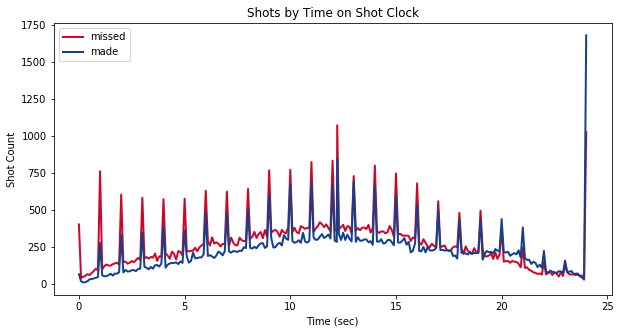

In [23]:
plt.figure(figsize=(10,5))
plt.plot(missed_shots_df.groupby('SHOT_CLOCK').count()['FGM'], c='#C9082A', label='missed', linewidth=2)
plt.plot(made_shots_df.groupby('SHOT_CLOCK').count()['FGM'], c='#17408B', label='made', linewidth=2)
plt.title('Shots by Time on Shot Clock')
plt.xlabel('Time (sec)')
plt.ylabel('Shot Count')
plt.legend()
plt.show()

Comaring made and missed shots based on time left on the shot clock can notice that there are only more makes than misses when there still almost 20 secs left. Could signify that the quick shot is due to being wide open thus more likely to make the shot (fast break points).

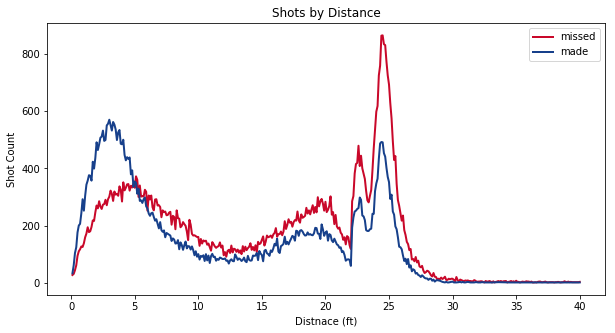

In [25]:
plt.figure(figsize=(10,5))
plt.plot(missed_shots_df.groupby('SHOT_DIST').count()['FGM'], c='#C9082A', label='missed', linewidth=2)
plt.plot(made_shots_df.groupby('SHOT_DIST').count()['FGM'], c='#17408B', label='made', linewidth=2)
plt.title('Shots by Distance')
plt.xlabel('Distnace (ft)')
plt.ylabel('Shot Count')
plt.legend()
plt.show()

We can see that by the graph that there are more made shots than misses for shot attempts very close to the basket, then as we get farther away from the basket there are more misses than makes.  Note there is a big spike in misses and makes around 22 feet suggesting teams are taking a lot of threes.
<br>

Let's take a look at how these shot attempts are broken up by their distance category.

In [26]:
# get shot distance categories for list
df[df['FGM']==0].groupby('shot_distance_category').count().index

Index(['close-range', 'deep threes', 'long twos', 'mid-range', 'threes'], dtype='object', name='shot_distance_category')

In [27]:
# get shot counts by category for missed and made shots
shot_distance_category = ['close-range', 'deep threes', 'long twos', 'mid-range', 'threes']
shots_missed_by_category = list(df[df['FGM']==0].groupby('shot_distance_category').count()['GAME_ID'])
print('missed:', shots_missed_by_category)
shots_made_by_category = list(df[df['FGM']==1].groupby('shot_distance_category').count()['GAME_ID'])
print('made:', shots_made_by_category)

missed: [20508, 389, 13087, 11646, 21689]
made: [27012, 45, 8892, 7846, 12064]


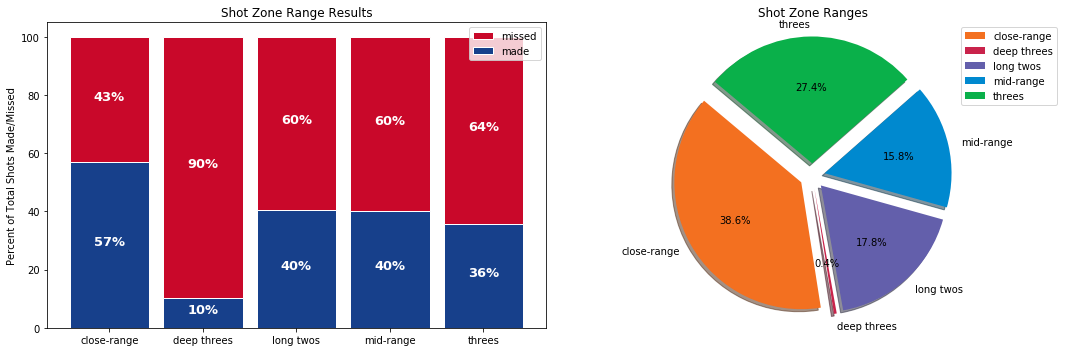

In [28]:
# Data
shot_distance_category = ['close-range', 'deep threes', 'long twos', 'mid-range', 'threes']
raw_data = {'missedBars': shots_missed_by_category, 'madeBars': shots_made_by_category}
bar_df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(bar_df['missedBars'], bar_df['madeBars'])]
missedBars = [i / j * 100 for i,j in zip(bar_df['missedBars'], totals)]
madeBars = [i / j * 100 for i,j in zip(bar_df['madeBars'], totals)]
 
# plot
barWidth = 0.85
plt.figure(figsize=(15,5))

# Create missed Bars
plt.subplot(1,2,1)
plt.bar(shot_distance_category, missedBars, bottom=madeBars, color='#C9082A', edgecolor='white', width=barWidth, label='missed')

# Create made Bars
plt.bar(shot_distance_category, madeBars, color='#17408B', edgecolor='white', width=barWidth, label='made')

# Custom axis
plt.legend()
plt.title('Shot Zone Range Results')
plt.ylabel('Percent of Total Shots Made/Missed')
for i, (missed, made) in enumerate(zip(missedBars,madeBars)):
    plt.text(i, (100-made)/2+made, str(round(missed))+'%', ha='center', color='white', weight='bold', fontsize=13)
    plt.text(i, made/2, str(round(made))+'%', ha='center',  color='white', weight='bold', fontsize=13)


labels = shot_distance_category
sizes = totals
colors = ['#F37020', '#C9234B', '#635FAB', '#0089CF', '#0AB04A']
explode = (0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.subplot(1,2,2)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Shot Zone Ranges')
plt.legend()
plt.tight_layout()

# show plot
plt.show()

As expected we can see majority of the shots taken and made are close to the basket.  What is interesting is how the amount of threes taken are greater than the mid-range and long two shots.  Also there isn't a big discrepancy between the amounts made and missed with those categories with the difference only being 4%.
<br>

Let's look at this relationship more specifically in regards to 2 point shots versus 3 point shots.

In [29]:
# get shots missed/made based on 2 point shot or 3 point shot
shots_missed_by_point_type = list(df[df['FGM']==0].groupby('PTS_TYPE').count()['GAME_ID'])
shots_made_by_point_type = list(df[df['FGM']==1].groupby('PTS_TYPE').count()['GAME_ID'])
print('missed:', shots_missed_by_point_type)
print('made:', shots_made_by_point_type)

missed: [46364, 20955]
made: [44396, 11463]


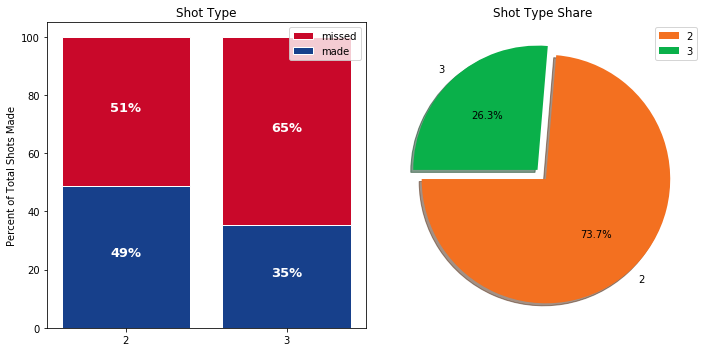

In [30]:
# Data
shot_types = ['2', '3']
raw_data = {'missedBars': shots_missed_by_point_type, 'madeBars': shots_made_by_point_type}
bar_df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(bar_df['missedBars'], bar_df['madeBars'])]
missedBars = [i / j * 100 for i,j in zip(bar_df['missedBars'], totals)]
madeBars = [i / j * 100 for i,j in zip(bar_df['madeBars'], totals)]
 
# plot
plt.figure(figsize=(10,5))

# Create missed Bars
plt.subplot(1,2,1)
plt.bar(shot_types, missedBars, bottom=madeBars, color='#C9082A', edgecolor='white', label='missed')

# Create made Bars
plt.bar(shot_types, madeBars, color='#17408B', edgecolor='white', label='made')

# Custom axis
plt.legend()
plt.title('Shot Type')
plt.ylabel('Percent of Total Shots Made')
for i, (missed, made) in enumerate(zip(missedBars,madeBars)):
    plt.text(i, (100-made)/2+made, str(round(missed))+'%', ha='center', color='white', weight='bold', fontsize=13)
    plt.text(i, made/2, str(round(made))+'%', ha='center',  color='white', weight='bold', fontsize=13)


labels = shot_types
sizes = totals
colors = ['#F37020', '#0AB04A']
explode = (0.1, 0.0)  # explode 1st slice
 
# Plot
plt.subplot(1,2,2)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title('Shot Type Share')
plt.legend()
plt.tight_layout()

# show plot
plt.show()

Here we can see the it is almost a 50-50 chance of making or missing a 2-point shot where 3-point shots have over 1/3 chance of making the shot.  This is interesting because looking at expected points per shot it seems advantageous to take more 3's. 
<br>
E[2's] = 0.49 * 2 = .98 points
<br>
E[3's] = 0.35 * 3 = 1.05 points
<br>
Let's see if we can dig deeper by looking at points per shot by distance.

In [31]:
# Create new df to get points per shot
pps_df = pd.DataFrame(index=sorted(list(df.SHOT_DIST.unique())), columns=['total_shots', 'points'])
pps_df['total_shots'] = df.groupby('SHOT_DIST').count()['GAME_ID']
pps_df['points'] = df.groupby('SHOT_DIST').sum()['PTS']
pps_df['pps'] = round(pps_df.points / pps_df.total_shots, 2)
pps_df.head()

,total_shots,points,pps
0.1,60,66,1.10
0.2,92,122,1.33
0.3,148,208,1.41
0.4,185,248,1.34
0.5,270,352,1.30


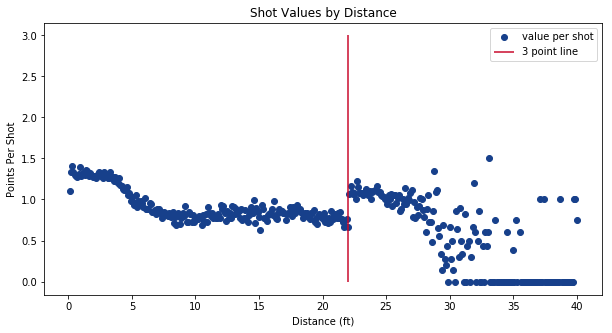

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(x=pps_df.index, y=pps_df.pps, color='#17408B', label='value per shot')
plt.vlines(x=22, ymin=0, ymax=3, color='#C9082A', label='3 point line')
plt.title('Shot Values by Distance')
plt.xlabel('Distance (ft)')
plt.ylabel('Points Per Shot')
plt.legend()
plt.show()

Here we can see that the most valuable shots are from about 0 to 5 feet, then the value drops for longer two point shots as the value hovers right below 0.8 pps.  Then right at 22 feet, where the corner three point lines are, the value jumps up, being more valuable than the long two point shots. This is the reason we saw more shots being taken for three point shots versus long twos and mid-range shots.
<br>

Now let's explore the data with regards to the individual players in order to identify the top shooters and top defenders based on the dataset.  

In [33]:
# Create player df
data = pd.read_csv('shot_logs_Height.csv')
shooterID_list = list(data.player_id.unique())
defenderID_list = list(data.CLOSEST_DEFENDER_PLAYER_ID.unique())

player_df = pd.DataFrame(index=shooterID_list, columns=['player', 'made', 'missed', 'FG%', 'FG_dist',
                                                'made_against', 'missed_against', 'FG%_against', 'FG_dist_against'])
for shooterID in shooterID_list:
    name = data[data['player_id']==shooterID]['player_name'].iloc[0]
    made = np.sum(data[data['player_id']==shooterID]['FGM']==1)
    missed = np.sum(data[data['player_id']==shooterID]['FGM']==0)
    percentage = made/(made+missed)
    avg_distance = np.mean(data[data['player_id']==shooterID]['SHOT_DIST'])
    
    player_df.loc[shooterID, 'player'] = name
    player_df.loc[shooterID, 'made'] = made
    player_df.loc[shooterID, 'missed'] = missed
    player_df.loc[shooterID, 'FG%'] = percentage
    player_df.loc[shooterID, 'FG_dist'] = avg_distance
    
for defenderID in defenderID_list:
    made = np.sum(data[data['CLOSEST_DEFENDER_PLAYER_ID']==defenderID]['FGM']==1)
    missed = np.sum(data[data['CLOSEST_DEFENDER_PLAYER_ID']==defenderID]['FGM']==0)
    percentage = made / (made+missed)
    avg_distance = np.mean(data[data['CLOSEST_DEFENDER_PLAYER_ID']==defenderID]['SHOT_DIST'])
    
    player_df.loc[defenderID, 'made_against'] = made
    player_df.loc[defenderID, 'missed_against'] = missed
    player_df.loc[defenderID, 'FG%_against'] = percentage
    player_df.loc[defenderID, 'FG_dist_against'] = avg_distance

player_df.drop(player_df[player_df['missed_against']<200].index, inplace=True)

In [34]:
player_df.head()

,player,made,missed,FG%,FG_dist,made_against,missed_against,FG%_against,FG_dist_against
2744,al jefferson,382,418,0.4775,9.31537,289,283,0.505245,10.2741
203469,cody zeller,165,190,0.464789,10.6327,225,294,0.433526,12.3343
201945,gerald henderson,246,317,0.436945,14.5597,170,238,0.416667,17.6865
202689,kemba walker,278,417,0.4,14.8394,225,301,0.427757,15.9751
101107,marvin williams,140,178,0.440252,19.3969,168,202,0.454054,13.1811


In [35]:
# Top defenders (min 200 missed shots against)
player_df.sort_values('FG%_against').head(10)

,player,made,missed,FG%,FG_dist,made_against,missed_against,FG%_against,FG_dist_against
2754,tony allen,172,186,0.480447,6.13128,113,205,0.355346,15.7648
203460,andre roberson,77,91,0.458333,12.0464,120,200,0.375,14.1553
101106,andrew bogut,132,107,0.552301,5.18326,168,265,0.387991,9.59792
201564,O.J. Mayo,236,335,0.41331,16.5105,140,220,0.388889,16.8942
203114,khris middleton,265,297,0.47153,15.4311,165,256,0.391924,16.1936
203497,rudy gobert,167,100,0.625468,3.55131,192,297,0.392638,8.85481
201939,stephen curry,470,498,0.485537,17.4705,209,318,0.396584,15.9632
202709,cory joseph,175,171,0.50578,9.9922,158,238,0.39899,14.7586
201952,jeff teague,319,368,0.464338,11.7983,169,254,0.399527,18.0957
203110,draymond green,242,310,0.438406,14.9168,301,450,0.400799,12.4647


Here we can see a list of the players based on their FG% against, basically the percentage of shots that went in when they were the closest defender when a minimum of 200 shots were taken against them.

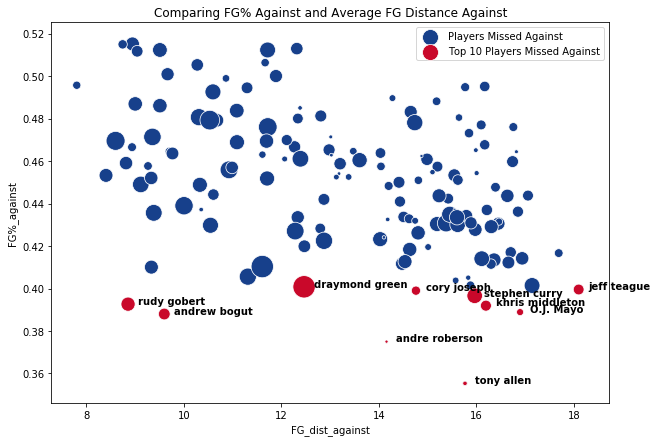

In [36]:
top_10_defenders = player_df.sort_values('FG%_against').head(10)

plt.figure(figsize=(10,7))
sns.scatterplot(x=player_df['FG_dist_against'], y=player_df['FG%_against'], size=player_df['missed_against'],
                legend=False, sizes=(10,500), color='#17408B')
sns.scatterplot(x=top_10_defenders['FG_dist_against'], y=top_10_defenders['FG%_against'], size=top_10_defenders['missed_against'], 
                legend=False, sizes=(10,500), color='#C9082A')
for i, (player, fg_against, fg_dist_against) in enumerate(zip(list(top_10_defenders.player), list(top_10_defenders['FG%_against']), list(top_10_defenders['FG_dist_against']))):
    plt.text(fg_dist_against+.2, fg_against, str(player), weight='semibold')
    
plt.title('Comparing FG% Against and Average FG Distance Against')
plt.legend(('Players Missed Against', 'Top 10 Players Missed Against'))
plt.show()

The above chart highlights the top ten defenders by FG% against where the size represents the amount of shots that have been missed against them.  It's easy to notice that they all have the lowest FG% against for their respective FG distance against.  This signifies that they are the best at guarding their position.

In [37]:
# Top shooters (min 15ft and 200 made)
player_df[(player_df['FG_dist']>=15)&(player_df['made']>=200)].sort_values('FG%', ascending=False).iloc[:,:5].head(10)

,player,made,missed,FG%,FG_dist
2594,kyle korver,235,243,0.491632,22.01
201939,stephen curry,470,498,0.485537,17.4705
101108,chris paul,425,460,0.480226,16.6165
201954,darren collison,260,290,0.472727,15.2962
201584,courtney lee,225,251,0.472689,16.4216
203114,khris middleton,265,297,0.47153,15.4311
201586,serge ibaka,346,389,0.470748,15.3803
202691,klay thompson,449,522,0.46241,16.7906
1717,Dirk Nowitzki,377,439,0.46201,17.2668
200755,jj redick,299,350,0.460709,19.5037


Here is a list of the top 10 shooters based on their FG% for players with at least an average FG distance of 15 feet and who have taken at least 200 shots.

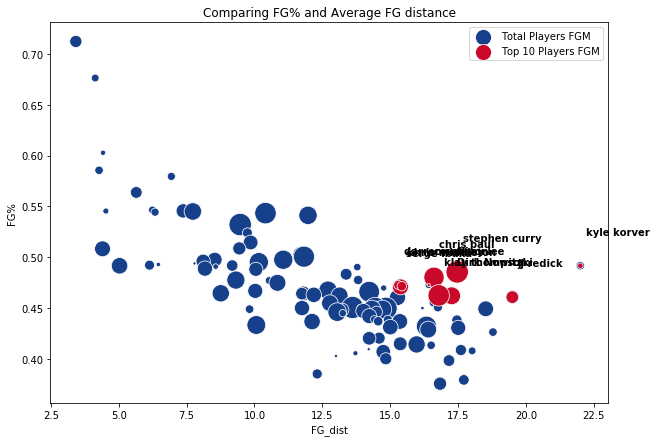

In [38]:
shooters_df = player_df[player_df['made']>200].sort_values('FG%', ascending=False).iloc[:,:5]
top_10_shooters = player_df[(player_df['FG_dist']>15)&(player_df['made']>200)].sort_values('FG%', ascending=False).iloc[:,:5].head(10)

plt.figure(figsize=(10,7))
sns.scatterplot(x=shooters_df['FG_dist'], y=shooters_df['FG%'], size=shooters_df['made'],
                legend=False, sizes=(10,500), color='#17408B')
sns.scatterplot(x=top_10_shooters['FG_dist'], y=shooters_df['FG%'], size=top_10_shooters['made'], 
                legend=False, sizes=(10,500), color='#C9082A')
for i, (player, fg, fg_dist) in enumerate(zip(list(top_10_shooters.player), list(top_10_shooters['FG%']), list(top_10_shooters['FG_dist']))):
    plt.text(fg_dist+.2, fg+.03, str(player), weight='semibold')

plt.title('Comparing FG% and Average FG distance')
plt.legend(('Total Players FGM', 'Top 10 Players FGM'))
plt.show()

The above graph shows the top shooters having the highest FG% for average distance of at least 15 feet where the size represents the amount of shots they have made.

## Modeling

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123178 entries, 0 to 128068
Data columns (total 27 columns):
GAME_ID                       123178 non-null int64
LOCATION                      123178 non-null int64
FINAL_MARGIN                  123178 non-null int64
SHOT_NUMBER                   123178 non-null int64
PERIOD                        123178 non-null int64
GAME_CLOCK                    123178 non-null int64
SHOT_CLOCK                    123178 non-null float64
DRIBBLES                      123178 non-null int64
TOUCH_TIME                    123178 non-null float64
SHOT_DIST                     123178 non-null float64
PTS_TYPE                      123178 non-null int64
CLOSEST_DEFENDER              123178 non-null object
CLOSEST_DEFENDER_PLAYER_ID    123178 non-null int64
CLOSE_DEF_DIST                123178 non-null float64
FGM                           123178 non-null int64
PTS                           123178 non-null int64
player_name                   123178 non-null ob

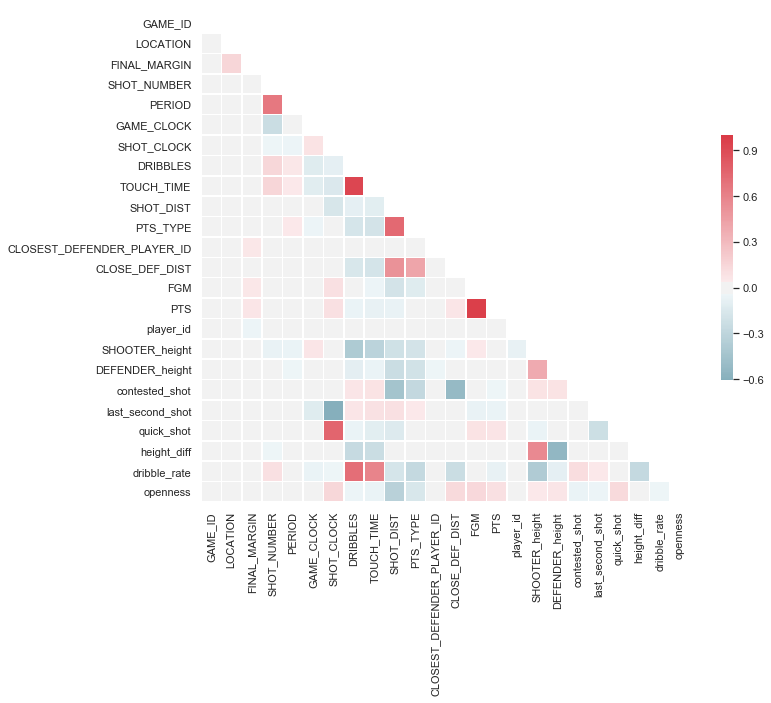

In [40]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False);

In [61]:
# Columns to Drop based on collinearity or not useful in shot prediction
features_to_drop = ['GAME_ID', 'player_name', 'CLOSEST_DEFENDER', 'PTS', 'PTS_TYPE', 'PERIOD',
                    'FINAL_MARGIN', 'DRIBBLES']
model_df = df.drop(features_to_drop, axis=1)

In [62]:
# Separate into train and test data
X = model_df.drop('FGM', axis=1)
y = model_df.FGM
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [63]:
# Get baseline model: model that would predict the majority outcome
miss = np.where(y_test==0)[0].size
made = np.where(y_test==1)[0].size
print(miss, made)
print(miss/(miss+made))

16714 14081
0.5427504465010554


Here we have our baseline model of predicting all misses which would give us an accuracy of about 55%

### XGBoost

In [64]:
print('All Features')
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds = clf_xgb.predict(X_train)
test_preds = clf_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

All Features
Training Accuracy: 62.62%
Test Accuracy: 62.3%


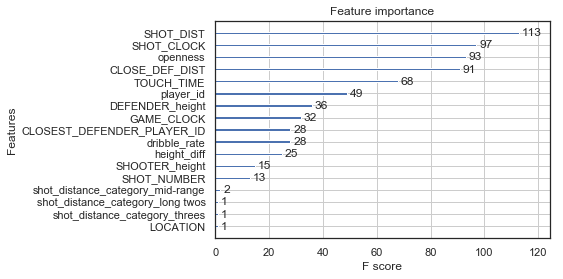

In [65]:
plot_importance(clf_xgb, importance_type='weight')
plt.show()

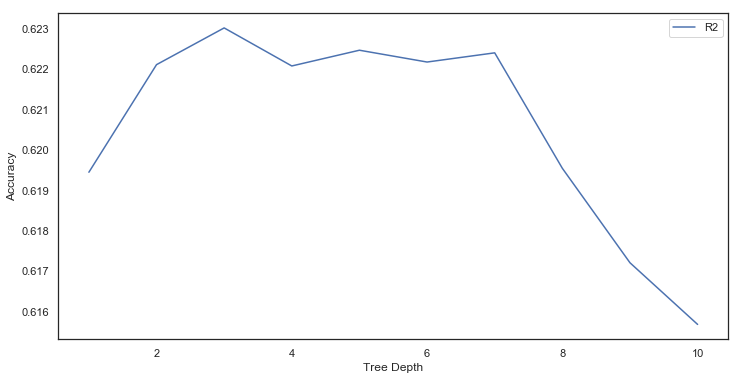

In [66]:
# Identify the optimal tree depth for given data
max_depths = np.arange(1,11)
acc_results = []

for max_depth in max_depths:
    regressor = XGBClassifier(max_depth=max_depth, random_state=45)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    acc_results.append(score)
    

plt.figure(figsize=(12,6))
plt.plot(max_depths, acc_results, 'b', label='Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [67]:
# Make model with top features, exclude FINAL_MARGIN since shots should be dependent of final game score
print('Top Features')
X_train, X_test, y_train, y_test = train_test_split(X_scaled[['SHOT_DIST', 'CLOSE_DEF_DIST', 
                                                              'SHOT_CLOCK', 'openness', 'TOUCH_TIME']], y, random_state=0)
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds = clf_xgb.predict(X_train)
test_preds = clf_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

Top Features
Training Accuracy: 62.36%
Test Accuracy: 62.02%


The XGB model produces about 62% accuracy, although it beats the baseline model by 7%, it's still not great.  Let's use GridSearch to tune some of the parameters.

In [68]:
clf_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [69]:
print('Grid Search Top Features')

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,7],
    'min_child_weight': [1, 10],
    'subsample': [ 0.7],
    'n_estimators': [100, 250],
}

grid_clf = GridSearchCV(clf_xgb, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

Grid Search Top Features
Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 62.36%
Test Accuracy: 61.95%


              precision    recall  f1-score   support

           0       0.61      0.86      0.71     16714
           1       0.67      0.33      0.44     14081

   micro avg       0.62      0.62      0.62     30795
   macro avg       0.64      0.60      0.58     30795
weighted avg       0.63      0.62      0.59     30795



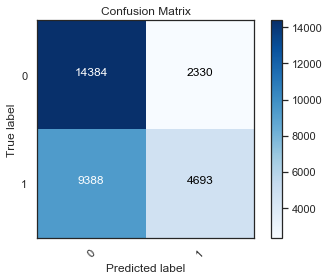

In [70]:
cnf_matrix = confusion_matrix(y_test, test_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar();
print(classification_report(y_test, test_preds))

Even after GridSearch we still get an accuracy of 62%

### Logistic Regression

In [71]:
print('All Features')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)
clf_log = LogisticRegression(C=1e12, fit_intercept=False)
clf_log.fit(X_train, y_train)
training_preds = clf_log.predict(X_train)
test_preds = clf_log.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

All Features


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy: 60.23%
Test Accuracy: 60.56%


In [393]:
print('Top Features')
X_train, X_test, y_train, y_test = train_test_split(X_scaled[['SHOT_DIST', 'CLOSE_DEF_DIST', 
                                                              'SHOT_CLOCK', 'openness', 'TOUCH_TIME']], y, random_state=0)
clf_log = LogisticRegression(C=1e12, fit_intercept=False)
clf_log.fit(X_train, y_train)
training_preds = clf_log.predict(X_train)
test_preds = clf_log.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

Top Features


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy: 59.57%
Test Accuracy: 60.06%


In [380]:
clf_log.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)>

In [381]:
print('Grid Search Top Features')

param_grid = {
     'penalty' : ['l1', 'l2'],
    'C' : [1, 1000, 1e12],
    'solver' : ['liblinear'],
    'fit_intercept': [True, False]
}

grid_clf = GridSearchCV(clf_log, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Grid Search Top 4 Features
Grid Search found the following optimal parameters: 
C: 1
fit_intercept: True
penalty: 'l2'
solver: 'liblinear'

Training Accuracy: 60.97%
Test accuracy: 61.52%


In [382]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)
roc_auc

0.6022858105173655

              precision    recall  f1-score   support

           0       0.60      0.75      0.67     16315
           1       0.56      0.39      0.46     13483

   micro avg       0.59      0.59      0.59     29798
   macro avg       0.58      0.57      0.56     29798
weighted avg       0.58      0.59      0.57     29798



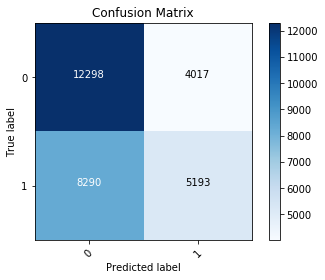

In [390]:
cnf_matrix = confusion_matrix(y_test, test_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()
print(classification_report(y_test, test_preds))

In [391]:
clf_log.coef_

array([[-0.57266199,  0.30490287,  0.10300292, -0.09396802]])

The LogisticRegression model ended up being about 60% accuracy.

### Random Forest

In [401]:
print('All Features')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
training_preds = clf_rf.predict(X_train)
test_preds = clf_rf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

All Features


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Accuracy: 98.23%
Test Accuracy: 58.63%


Woah, here we get some serious overfitting, this probably has to do with the depth for each tree in the forest.

In [393]:
clf_rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

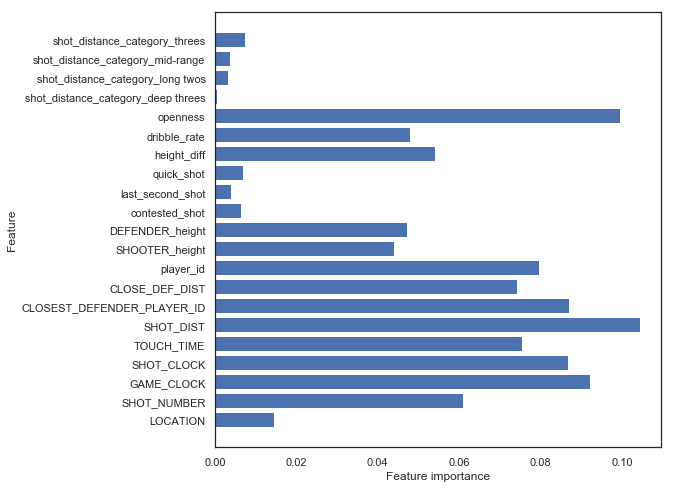

In [395]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf_rf)

In [396]:
print('Grid Search')

param_grid = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4],
    'min_samples_split': [0.1, 0.2],
    'min_samples_leaf': [0.1, 0.2]
}

grid_clf = GridSearchCV(clf_rf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Grid Search
Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 3
min_samples_leaf: 0.1
min_samples_split: 0.1
n_estimators: 100

Training Accuracy: 61.83%
Test accuracy: 61.79%


In [ ]:
cnf_matrix = confusion_matrix(y_test, test_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()
print(classification_report(y_test, test_preds))

The RandomForest model also got a similar accuracy score of about 61%. 

## Interpret

Based on the findings from the above models, it seems that the best model would be XGBoost, which showed the most important features to be SHOT_DIST and SHOT_CLOCK, while CLOSE_DEF_DIST and openness also had some importance as well.  The accuracy score ended up only beating the baseline model by 7%, probably not good enough to be used by any teams based on the dataset.  
<br>
Despite the low accuracy score, the dataset provided interesting insight on the relationship between shot distance and the amount of shots made/missed.  It also showed how the most efficient shots were around the basket at less than 8 feet and then three point shots at around 22 feet.  The mid-range and long two shots showed to be the least efficient shots based on points per shot.  With regards to shot clock, the data showed there were more makes than misses when there were about 18 seconds or more left on the clock showing that fast break points greatly influence makes. 
<br>
The dataset also allowed for exploration into top defenders and shooters based on FG% and defensive FG% along with distance.  

## Future Work

Possibly doing a more extensive GridSearch could improve the model, also data that incorporates tracking and location at the point of shot would be more helpful in classifying made/missed shots.

Had difficulty coming up with a good metric to represent openness, mine was a simple metric but possibly collecting more data about how open you are when shooting with relation to how far away you are from the basket, like a shot difficulty measure, would be more helpful in classifying.  

Similar classifications might be better using visual data of images where everyone is at on the court when the player shoots the shot.  Could bring insight into certain plays or player movements that are used to predict the outcome of a shot as well.